# Detecting Human Activities Through Smartphone Sensor - Training

## Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import glob
from tqdm import tqdm
import seaborn as sns
import filecmp
from sklearn.preprocessing import MaxAbsScaler
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
import warnings
from sklearn.linear_model import LogisticRegression
import pydot
from IPython.display import Image
from mlxtend import plotting
from six import StringIO
from sklearn.tree import export_graphviz
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit

## Global Variables

In [2]:
PBAR_FORMAT='{desc:12}{percentage:3.0f}%|{bar:27}[ {n:4d}/{total:4d}, {elapsed}<{remaining}{postfix} ]'

ACTIVITY_CODES_MAP = {'A': 'walking',
                          'B': 'jogging',
                          'C': 'stairs',
                          'D': 'sitting',
                          'E': 'standing',
                          'F': 'typing',
                          'G': 'brushing teeth',
                          'H': 'eating soup',
                          'I': 'eating chips',
                          'J': 'eating pasta',
                          'K': 'drinking from cup',
                          'L': 'eating sandwich',
                          'M': 'kicking soccer ball',
                          'O': 'playing catch tennis ball',
                          'P': 'dribbling basket ball',
                          'Q': 'writing',
                          'R': 'clapping',
                          'S': 'folding clothes'}

ACTIVITY_NAMES = ["walking", "jogging", "stairs", "sitting", "standing", "typing", "brushing teeth",
                  "eating soup", "eating chips", "eating pasta", "drinking from cup", "eating sandwich",
                  "kicking soccer ball", "playing catch tennis ball", "dribbling basket ball",
                  "writing", "clapping", "folding clothes"]

# csv file column names
COL_NAMES =  ['id' , 'activity_code' , 'timestamp', 'x', 'y', 'z']
# training verbose
VERBOSE = 1
# rnadom state for split
RANDOM_STATE=12345

## Extracted Features

In [3]:
EXTRACTED_FEATURES = ['ACTIVITY',
                        'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9',
                        'Y0', 'Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9',
                        'Z0', 'Z1', 'Z2', 'Z3', 'Z4', 'Z5', 'Z6', 'Z7', 'Z8', 'Z9',
                        'XAVG', 'YAVG', 'ZAVG',
                        'XABSOLDEV', 'YABSOLDEV', 'ZABSOLDEV',
                        'XSTANDDEV', 'YSTANDDEV', 'ZSTANDDEV',
                        'XVAR', 'YVAR', 'ZVAR',
                        'XMFCC0', 'XMFCC1', 'XMFCC2', 'XMFCC3', 'XMFCC4',
                        'XMFCC5', 'XMFCC6', 'XMFCC7',
                        'XMFCC8', 'XMFCC9', 'XMFCC10', 'XMFCC11', 'XMFCC12',
                        'YMFCC0', 'YMFCC1', 'YMFCC2', 'YMFCC3', 'YMFCC4',
                        'YMFCC5', 'YMFCC6', 'YMFCC7',
                        'YMFCC8', 'YMFCC9', 'YMFCC10', 'YMFCC11', 'YMFCC12',
                        'ZMFCC0', 'ZMFCC1', 'ZMFCC2', 'ZMFCC3', 'ZMFCC4',
                        'ZMFCC5', 'ZMFCC6', 'ZMFCC7',
                        'ZMFCC8', 'ZMFCC9', 'ZMFCC10', 'ZMFCC11', 'ZMFCC12',
                        'XYCOS', 'XZCOS', 'YZCOS',
                        'XYCOR', 'XZCOR', 'YZCOR',
                        'RESULTANT',
                        'PARTICIPANT'] # Categirical: 1600 -1650

len(EXTRACTED_FEATURES)


90

## Dataset

In [4]:
def WISDM_Dataset(DATA_DIR):
    all_files = glob.glob(DATA_DIR + "/*.txt")

    list_dfs = []
    for filename in all_files:
        df = pd.read_csv(filename, names = EXTRACTED_FEATURES, index_col=None, header=0)
        list_dfs.append(df)

    all_data = pd.concat(list_dfs, axis=0, ignore_index=True, sort=False)

    return all_data

## Training on Phone - Accelerometer

### Hyper parameters

In [5]:
NUM_SPLITS=5
TRAIN_SIZE=0.8
TEST_SIZE=1-TRAIN_SIZE

my_param_grid = {'C': [10, 50, 100, 200]}
DATA_DIR="../dataset/processed/phone/accel"

### Initialize Dataset

In [6]:
all_phone_accel = WISDM_Dataset(DATA_DIR)

# The approach in this analysis will be to see all the participants as a single, unified group.
# The aim of this analysis is not to examine differences between participants.
all_phone_accel.drop('PARTICIPANT', axis = 1, inplace = True)

y = all_phone_accel.ACTIVITY
X = all_phone_accel.drop('ACTIVITY', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size = TRAIN_SIZE,
                                                    test_size = TEST_SIZE,
                                                    shuffle = True,
                                                    stratify = y)

# Temporarily re-unite the train lables to train dataset for further preprocessing steps.
X_train.insert(0, 'Y', y_train)

# separating y_train
y_train = X_train['Y']
X_train.drop(['Y'], axis = 1, inplace = True)

# rescaling is applied to the features that their absolute values exceed the range of ~1
rescalin_features=['XAVG', 'YAVG', 'ZAVG', 'XABSOLDEV', 'YABSOLDEV', 'ZABSOLDEV', 'RESULTANT']
scaling_transformer = MaxAbsScaler().fit(X_train[rescalin_features])
X_train[rescalin_features] = scaling_transformer.transform(X_train[rescalin_features])

X_test = X_test.copy()
X_test[rescalin_features] = scaling_transformer.transform(X_test[rescalin_features])

# resetting the indices
X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)

In [7]:
X_train.columns

Index(['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'Y0', 'Y1',
       'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9', 'Z0', 'Z1', 'Z2', 'Z3',
       'Z4', 'Z5', 'Z6', 'Z7', 'Z8', 'Z9', 'XAVG', 'YAVG', 'ZAVG', 'XABSOLDEV',
       'YABSOLDEV', 'ZABSOLDEV', 'XSTANDDEV', 'YSTANDDEV', 'ZSTANDDEV', 'XVAR',
       'YVAR', 'ZVAR', 'XMFCC0', 'XMFCC1', 'XMFCC2', 'XMFCC3', 'XMFCC4',
       'XMFCC5', 'XMFCC6', 'XMFCC7', 'XMFCC8', 'XMFCC9', 'XMFCC10', 'XMFCC11',
       'XMFCC12', 'YMFCC0', 'YMFCC1', 'YMFCC2', 'YMFCC3', 'YMFCC4', 'YMFCC5',
       'YMFCC6', 'YMFCC7', 'YMFCC8', 'YMFCC9', 'YMFCC10', 'YMFCC11', 'YMFCC12',
       'ZMFCC0', 'ZMFCC1', 'ZMFCC2', 'ZMFCC3', 'ZMFCC4', 'ZMFCC5', 'ZMFCC6',
       'ZMFCC7', 'ZMFCC8', 'ZMFCC9', 'ZMFCC10', 'ZMFCC11', 'ZMFCC12', 'XYCOS',
       'XZCOS', 'YZCOS', 'XYCOR', 'XZCOR', 'YZCOR', 'RESULTANT'],
      dtype='object')

### Training

In [8]:
my_cv = StratifiedShuffleSplit(n_splits=NUM_SPLITS,
                               train_size=TRAIN_SIZE,
                               test_size=TEST_SIZE)


lr_classifier = LogisticRegression(verbose = 0, solver='liblinear', max_iter=100)
lr_model_gs = GridSearchCV(estimator=lr_classifier,
                           param_grid=my_param_grid,
                           cv=my_cv,
                           scoring = 'accuracy')
lr_model_gs.fit(X_train, y_train)
lr_best_classifier = lr_model_gs.best_estimator_
print(lr_model_gs.best_params_)
print(lr_model_gs.cv_results_)
print(lr_best_classifier.get_params())

{'C': 200}
{'mean_fit_time': array([10.29732823, 14.32400913, 16.11257653, 17.89177575]), 'std_fit_time': array([0.24335983, 0.45470822, 0.41890058, 0.97697749]), 'mean_score_time': array([0.00886126, 0.00870056, 0.00873175, 0.00870066]), 'std_score_time': array([1.63679896e-04, 5.69213360e-05, 4.56808007e-05, 4.53094170e-05]), 'param_C': masked_array(data=[10, 50, 100, 200],
             mask=[False, False, False, False],
       fill_value=999999), 'params': [{'C': 10}, {'C': 50}, {'C': 100}, {'C': 200}], 'split0_test_score': array([0.37266515, 0.37585421, 0.3785877 , 0.37904328]), 'split1_test_score': array([0.38132118, 0.38678815, 0.3881549 , 0.3881549 ]), 'split2_test_score': array([0.36492027, 0.37357631, 0.37494305, 0.37585421]), 'split3_test_score': array([0.36127563, 0.37539863, 0.3785877 , 0.37813212]), 'split4_test_score': array([0.37722096, 0.37904328, 0.3785877 , 0.3785877 ]), 'mean_test_score': array([0.37148064, 0.37813212, 0.37977221, 0.37995444]), 'std_test_score': arra

### Evaluation

#### Train Accuracy

In [9]:
scores = cross_val_score(lr_best_classifier, X_train, y_train, cv=my_cv, scoring='accuracy')
print(list(scores))

lr_best_classifier.score(X_train, y_train)
y_train_pred = lr_best_classifier.predict(X_train)

print("######################################################################################")
print("train accuracy:", 100 * accuracy_score(y_true=y_train, y_pred=y_train_pred))
print("######################################################################################")

[0.3854214123006834, 0.3744874715261959, 0.38086560364464694, 0.38223234624145785, 0.35444191343963555]
######################################################################################
train accuracy: 42.56036446469248
######################################################################################


#### Confusion Matrix

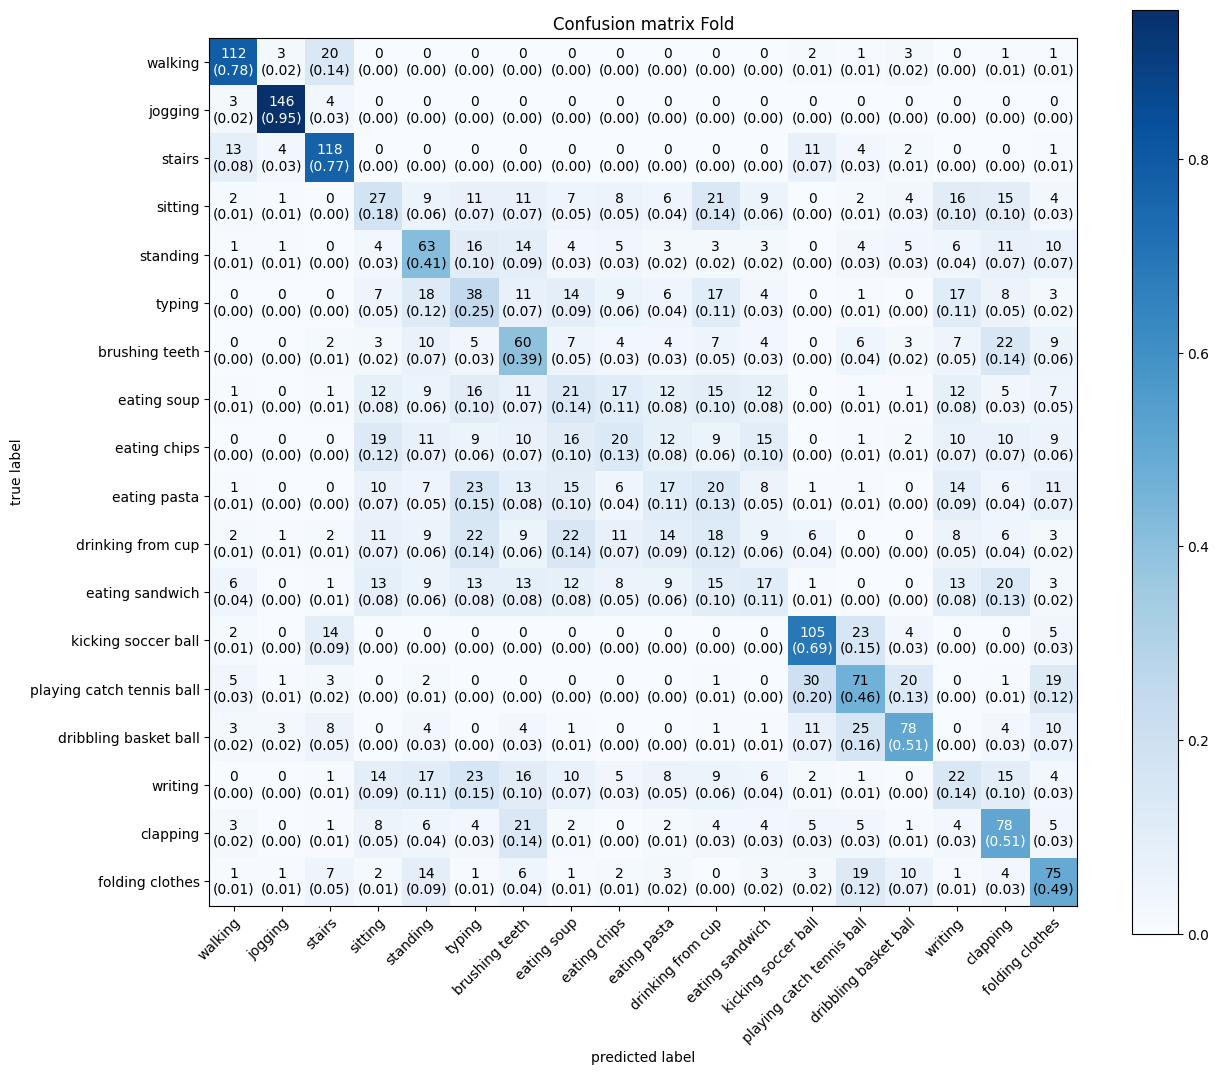

In [10]:
y_test_pred = lr_best_classifier.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_test_pred)
plotting.plot_confusion_matrix(conf_mat = conf_matrix,
                               class_names = ACTIVITY_NAMES,
                               show_normed = True,
                               figsize = (14, 12),
                               colorbar = True)
plt.title("Confusion matrix Fold")
plt.show()

#### Accuracy Per Activity

In [11]:
cm_act = pd.DataFrame(conf_matrix,
                      index=lr_best_classifier.classes_,
                      columns=lr_best_classifier.classes_)

cm_act.columns = ACTIVITY_CODES_MAP.values()
cm_act.index = ACTIVITY_CODES_MAP.values()
accuracy_per_activity = pd.DataFrame([cm_act.iloc[i][i]/np.sum(cm_act.iloc[i]) for i in range(18)],index=ACTIVITY_CODES_MAP.values())
print(accuracy_per_activity)

                                  0
walking                    0.783217
jogging                    0.954248
stairs                     0.771242
sitting                    0.176471
standing                   0.411765
typing                     0.248366
brushing teeth             0.392157
eating soup                0.137255
eating chips               0.130719
eating pasta               0.111111
drinking from cup          0.117647
eating sandwich            0.111111
kicking soccer ball        0.686275
playing catch tennis ball  0.464052
dribbling basket ball      0.509804
writing                    0.143791
clapping                   0.509804
folding clothes            0.490196


/tmp/ipykernel_2398363/2628092090.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  accuracy_per_activity = pd.DataFrame([cm_act.iloc[i][i]/np.sum(cm_act.iloc[i]) for i in range(18)],index=ACTIVITY_CODES_MAP.values())


#### Classification Report

In [12]:
print(classification_report(y_true=y_test,
                            y_pred=y_test_pred))
print("######################################################################################")

              precision    recall  f1-score   support

           A       0.72      0.78      0.75       143
           B       0.91      0.95      0.93       153
           C       0.65      0.77      0.70       153
           D       0.21      0.18      0.19       153
           E       0.34      0.41      0.37       153
           F       0.21      0.25      0.23       153
           G       0.30      0.39      0.34       153
           H       0.16      0.14      0.15       153
           I       0.21      0.13      0.16       153
           J       0.18      0.11      0.14       153
           K       0.13      0.12      0.12       153
           L       0.18      0.11      0.14       153
           M       0.59      0.69      0.64       153
           O       0.43      0.46      0.45       153
           P       0.59      0.51      0.55       153
           Q       0.17      0.14      0.16       153
           R       0.38      0.51      0.43       153
           S       0.42    

#### Test Accuracy

In [13]:
print("test accuracy", 100 * accuracy_score(y_true=y_test, y_pred=y_test_pred))

test accuracy 39.57725947521865


## Training on Phone - Gyroscope

### Hyper parameters

In [14]:
NUM_SPLITS=5
TRAIN_SIZE=0.8
TEST_SIZE=1-TRAIN_SIZE

my_param_grid = {'C': [10, 50, 100, 200]}
DATA_DIR="../dataset/processed/phone/gyro"

### Initialize Dataset

In [15]:
all_phone_gyro = WISDM_Dataset(DATA_DIR)

# The approach in this analysis will be to see all the participants as a single, unified group.
# The aim of this analysis is not to examine differences between participants.
all_phone_gyro.drop('PARTICIPANT', axis = 1, inplace = True)

y = all_phone_gyro.ACTIVITY
X = all_phone_gyro.drop('ACTIVITY', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size = TRAIN_SIZE,
                                                    test_size = TEST_SIZE,
                                                    shuffle = True,
                                                    stratify = y)

# Temporarily re-unite the train lables to train dataset for further preprocessing steps.
X_train.insert(0, 'Y', y_train)

# separating y_train
y_train = X_train['Y']
X_train.drop(['Y'], axis = 1, inplace = True)

# rescaling is applied to the features that their absolute values exceed the range of ~1
rescalin_features=['XAVG', 'YAVG', 'ZAVG', 'XABSOLDEV', 'YABSOLDEV', 'ZABSOLDEV', 'RESULTANT']
scaling_transformer = MaxAbsScaler().fit(X_train[rescalin_features])
X_train[rescalin_features] = scaling_transformer.transform(X_train[rescalin_features])

X_test = X_test.copy()
X_test[rescalin_features] = scaling_transformer.transform(X_test[rescalin_features])

# resetting the indices
X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)

In [16]:
X_train.columns

Index(['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'Y0', 'Y1',
       'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9', 'Z0', 'Z1', 'Z2', 'Z3',
       'Z4', 'Z5', 'Z6', 'Z7', 'Z8', 'Z9', 'XAVG', 'YAVG', 'ZAVG', 'XABSOLDEV',
       'YABSOLDEV', 'ZABSOLDEV', 'XSTANDDEV', 'YSTANDDEV', 'ZSTANDDEV', 'XVAR',
       'YVAR', 'ZVAR', 'XMFCC0', 'XMFCC1', 'XMFCC2', 'XMFCC3', 'XMFCC4',
       'XMFCC5', 'XMFCC6', 'XMFCC7', 'XMFCC8', 'XMFCC9', 'XMFCC10', 'XMFCC11',
       'XMFCC12', 'YMFCC0', 'YMFCC1', 'YMFCC2', 'YMFCC3', 'YMFCC4', 'YMFCC5',
       'YMFCC6', 'YMFCC7', 'YMFCC8', 'YMFCC9', 'YMFCC10', 'YMFCC11', 'YMFCC12',
       'ZMFCC0', 'ZMFCC1', 'ZMFCC2', 'ZMFCC3', 'ZMFCC4', 'ZMFCC5', 'ZMFCC6',
       'ZMFCC7', 'ZMFCC8', 'ZMFCC9', 'ZMFCC10', 'ZMFCC11', 'ZMFCC12', 'XYCOS',
       'XZCOS', 'YZCOS', 'XYCOR', 'XZCOR', 'YZCOR', 'RESULTANT'],
      dtype='object')

### Training

In [17]:
my_cv = StratifiedShuffleSplit(n_splits=NUM_SPLITS,
                               train_size=TRAIN_SIZE,
                               test_size=TEST_SIZE)

lr_classifier = LogisticRegression(verbose = 0, solver='liblinear')
lr_model_gs = GridSearchCV(estimator=lr_classifier,
                           param_grid=my_param_grid,
                           cv=my_cv,
                           scoring = 'accuracy')
lr_model_gs.fit(X_train, y_train)
lr_best_classifier = lr_model_gs.best_estimator_
print(lr_model_gs.best_params_)
print(lr_model_gs.cv_results_)
print(lr_best_classifier.get_params())

/home/murthyl/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


/home/murthyl/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 100}
{'mean_fit_time': array([ 7.81396508, 12.19161315, 14.01115417, 16.36129003]), 'std_fit_time': array([0.4547948 , 0.48835333, 0.64457526, 0.50589602]), 'mean_score_time': array([0.0087368 , 0.00870247, 0.00870309, 0.00889034]), 'std_score_time': array([5.34413849e-05, 2.19611338e-05, 2.24648507e-05, 2.35527120e-04]), 'param_C': masked_array(data=[10, 50, 100, 200],
             mask=[False, False, False, False],
       fill_value=999999), 'params': [{'C': 10}, {'C': 50}, {'C': 100}, {'C': 200}], 'split0_test_score': array([0.37722096, 0.38405467, 0.38314351, 0.38542141]), 'split1_test_score': array([0.39179954, 0.39544419, 0.39589977, 0.39407745]), 'split2_test_score': array([0.36947608, 0.37995444, 0.3808656 , 0.37995444]), 'split3_test_score': array([0.37312073, 0.39271071, 0.39316629, 0.39316629]), 'split4_test_score': array([0.37813212, 0.38952164, 0.39544419, 0.39271071]), 'mean_test_score': array([0.37794989, 0.38833713, 0.38970387, 0.38906606]), 'std_test_score': arra

### Evaluation

#### Train Accuracy

In [18]:
scores = cross_val_score(lr_best_classifier, X_train, y_train, cv=my_cv, scoring='accuracy')
print(list(scores))

lr_best_classifier.score(X_train, y_train)
y_train_pred = lr_best_classifier.predict(X_train)

print("######################################################################################")
print("train accuracy:", 100 * accuracy_score(y_true=y_train, y_pred=y_train_pred))
print("######################################################################################")

[0.38997722095671983, 0.3867881548974943, 0.39635535307517084, 0.39225512528473805, 0.4009111617312073]
######################################################################################
train accuracy: 43.453302961275625
######################################################################################


#### Confusion Matrix

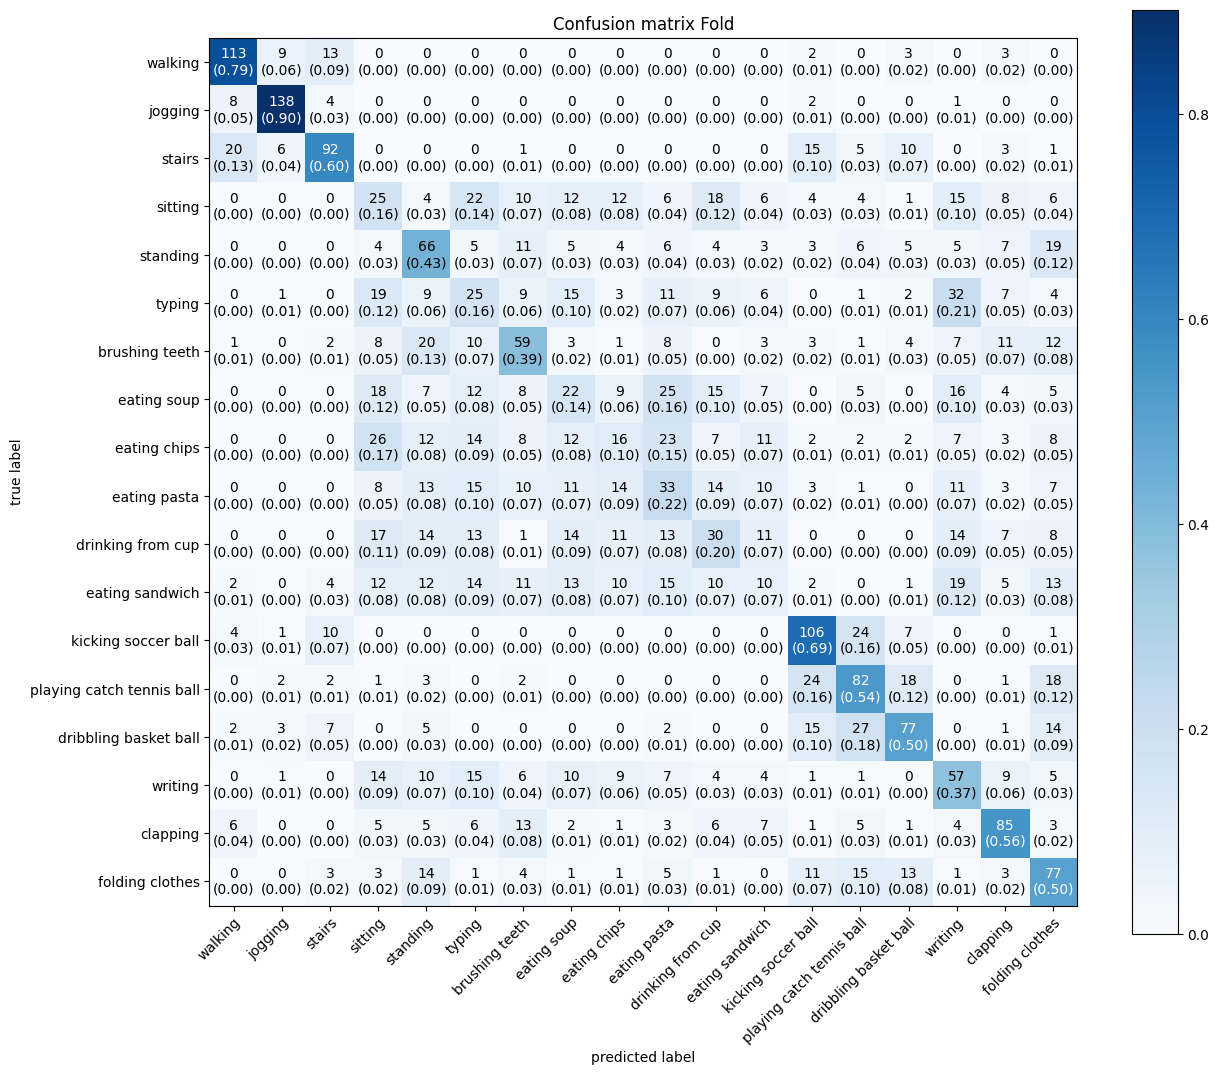

In [19]:
y_test_pred = lr_best_classifier.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_test_pred)
plotting.plot_confusion_matrix(conf_mat = conf_matrix,
                               class_names = ACTIVITY_NAMES,
                               show_normed = True,
                               figsize = (14, 12),
                               colorbar = True)
plt.title("Confusion matrix Fold")
plt.show()

#### Accuracy Per Activity

In [20]:
cm_act = pd.DataFrame(conf_matrix,
                      index=lr_best_classifier.classes_,
                      columns=lr_best_classifier.classes_)

cm_act.columns = ACTIVITY_CODES_MAP.values()
cm_act.index = ACTIVITY_CODES_MAP.values()
accuracy_per_activity = pd.DataFrame([cm_act.iloc[i][i]/np.sum(cm_act.iloc[i]) for i in range(18)],index=ACTIVITY_CODES_MAP.values())
print(accuracy_per_activity)

                                  0
walking                    0.790210
jogging                    0.901961
stairs                     0.601307
sitting                    0.163399
standing                   0.431373
typing                     0.163399
brushing teeth             0.385621
eating soup                0.143791
eating chips               0.104575
eating pasta               0.215686
drinking from cup          0.196078
eating sandwich            0.065359
kicking soccer ball        0.692810
playing catch tennis ball  0.535948
dribbling basket ball      0.503268
writing                    0.372549
clapping                   0.555556
folding clothes            0.503268


/tmp/ipykernel_2398363/2628092090.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  accuracy_per_activity = pd.DataFrame([cm_act.iloc[i][i]/np.sum(cm_act.iloc[i]) for i in range(18)],index=ACTIVITY_CODES_MAP.values())


#### Classification Report

In [21]:
print(classification_report(y_true=y_test,
                            y_pred=y_test_pred))
print("######################################################################################")

              precision    recall  f1-score   support

           A       0.72      0.79      0.76       143
           B       0.86      0.90      0.88       153
           C       0.67      0.60      0.63       153
           D       0.16      0.16      0.16       153
           E       0.34      0.43      0.38       153
           F       0.16      0.16      0.16       153
           G       0.39      0.39      0.39       153
           H       0.18      0.14      0.16       153
           I       0.18      0.10      0.13       153
           J       0.21      0.22      0.21       153
           K       0.25      0.20      0.22       153
           L       0.13      0.07      0.09       153
           M       0.55      0.69      0.61       153
           O       0.46      0.54      0.49       153
           P       0.53      0.50      0.52       153
           Q       0.30      0.37      0.33       153
           R       0.53      0.56      0.54       153
           S       0.38    

#### Test Accuracy

In [22]:
print("test accuracy", 100 * accuracy_score(y_true=y_test, y_pred=y_test_pred))

test accuracy 40.56122448979592
